In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
wine = pd.read_csv('white_wine.csv')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


## Preprocess

C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


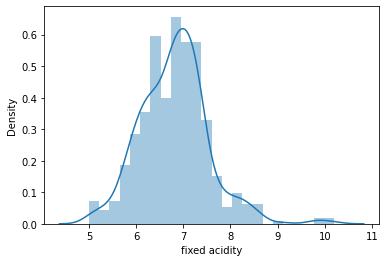

In [3]:
sns.distplot(wine['fixed acidity'])
plt.show()

C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


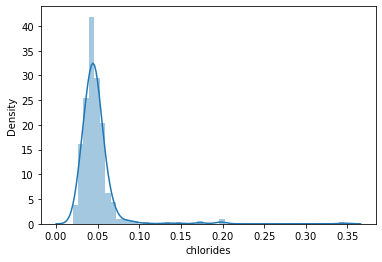

In [4]:
sns.distplot(wine['chlorides'])
plt.show()

In [5]:
def binning_acidity(value):
    if value > 8:
        result = 'high'
    elif value > 6.5:
        result = 'medium'
    else :
        result = 'low'
    return result

def binning_chlorides(value):
    if value > 0.07:
        result = 'high'
    elif value > 0.05:
        result = 'medium'
    else :
        result = 'low'
    return result

def labeling(value):
    if value > 6:
        result = 1
    else:
        result = 0
    return result

In [6]:
wine['fixed acidity level']=wine['fixed acidity'].apply(binning_acidity)
wine['chlorides level']=wine['chlorides'].apply(binning_chlorides)
wine['label']=wine['quality'].apply(labeling)

In [7]:
wine.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      1
sulphates               1
alcohol                 1
quality                 1
fixed acidity level     0
chlorides level         0
label                   0
dtype: int64

In [8]:
wine.dropna(inplace=True)

In [9]:
wine_deploy = wine[['alcohol','density','fixed acidity level','chlorides level','label']]
wine_train = wine_deploy[:400]
wine_test = wine_deploy[400:]

In [10]:
wine_train.to_csv('wine_train.csv',index=False)
wine_test.to_csv('wine_test.csv',index=False)

In [11]:
wine_train

,alcohol,density,fixed acidity level,chlorides level,label
0,8.8,1.0010,medium,low,0
1,9.5,0.9940,low,low,0
2,10.1,0.9951,high,low,0
3,9.9,0.9956,medium,medium,0
4,9.9,0.9956,medium,medium,0
...,...,...,...,...,...
395,10.0,0.9920,medium,low,0
396,11.4,0.9917,high,low,0
397,11.4,0.9917,low,low,0
398,9.4,0.9993,low,low,0


## Model Training

In [12]:
# Basic Operations
import pandas as pd
import numpy as np

# ML Models
from sklearn.linear_model import LogisticRegression

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer

# Evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Model
import pickle
import joblib


In [13]:
poly = PolynomialFeatures(degree=3, include_bias=False)
one_hot = OneHotEncoder(drop='first')

transformer = ColumnTransformer([
    ('poly',poly, ['alcohol','density']),
    ('onehot',one_hot, ['fixed acidity level','chlorides level'])
])

In [14]:
X = wine_train.drop(columns='label')
y = wine_train['label']

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,stratify=y,random_state = 2020)

model = LogisticRegression(solver='liblinear',random_state=2020)

estimator = Pipeline([
    ('preprocess',transformer),
    ('clf',model)
])

In [15]:
estimator.get_params()

{'memory': None,
 'steps': [('preprocess',
   ColumnTransformer(transformers=[('poly',
                                    PolynomialFeatures(degree=3,
                                                       include_bias=False),
                                    ['alcohol', 'density']),
                                   ('onehot', OneHotEncoder(drop='first'),
                                    ['fixed acidity level', 'chlorides level'])])),
  ('clf', LogisticRegression(random_state=2020, solver='liblinear'))],
 'verbose': False,
 'preprocess': ColumnTransformer(transformers=[('poly',
                                  PolynomialFeatures(degree=3,
                                                     include_bias=False),
                                  ['alcohol', 'density']),
                                 ('onehot', OneHotEncoder(drop='first'),
                                  ['fixed acidity level', 'chlorides level'])]),
 'clf': LogisticRegression(random_state=2020, solver='li

In [16]:
hyperparam_space = {
    'clf__C':[100,10,1,0.1,0.01,0.001],
    'clf__solver':['liblinear','newton-cg']
}
skfold = StratifiedKFold(n_splits=5)

grid = GridSearchCV(
    estimator,
    hyperparam_space,
    cv=skfold,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_val,y_train_val)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('poly',
                                                                         PolynomialFeatures(degree=3,
                                                                                            include_bias=False),
                                                                         ['alcohol',
                                                                          'density']),
                                                                        ('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['fixed '
                                                                          'acidity '
                                              

In [17]:
grid.best_params_

{'clf__C': 100, 'clf__solver': 'liblinear'}

In [18]:
logit_tuned = grid.best_estimator_
logit_tuned.fit(X_train_val,y_train_val)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('poly',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  ['alcohol', 'density']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['fixed acidity level',
                                                   'chlorides level'])])),
                ('clf',
                 LogisticRegression(C=100, random_state=2020,
                                    solver='liblinear'))])

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, logit_tuned.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97        81
           1       0.86      0.95      0.90        19

    accuracy                           0.96       100
   macro avg       0.92      0.96      0.94       100
weighted avg       0.96      0.96      0.96       100



## SEBELUM DISIMPEN HARUS DIFIT LAGI DENGAN data SEMUANYA


# Pake Pickle

## Pickle Save

In [20]:
X

,alcohol,density,fixed acidity level,chlorides level
0,8.8,1.0010,medium,low
1,9.5,0.9940,low,low
2,10.1,0.9951,high,low
3,9.9,0.9956,medium,medium
4,9.9,0.9956,medium,medium
...,...,...,...,...
395,10.0,0.9920,medium,low
396,11.4,0.9917,high,low
397,11.4,0.9917,low,low
398,9.4,0.9993,low,low


In [21]:
logit_tuned.fit(X,y)
filename = 'logit_final.sav'
pickle.dump(logit_tuned,open(filename,'wb'))

## Pickle Load

In [22]:
filename = 'logit_final.sav'
loaded_model = pickle.load(open(filename,'rb'))

In [23]:
loaded_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('poly',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  ['alcohol', 'density']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['fixed acidity level',
                                                   'chlorides level'])])),
                ('clf',
                 LogisticRegression(C=100, random_state=2020,
                                    solver='liblinear'))])

In [24]:
wine_test = pd.read_csv('wine_test.csv')
wine_X = wine_test.drop('label',axis=1)
wine_y = wine_test['label']

In [25]:
y_pred = loaded_model.predict(wine_X)
print(classification_report(y_pred,wine_y))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       100
           1       0.86      0.95      0.90        19

    accuracy                           0.97       119
   macro avg       0.92      0.96      0.94       119
weighted avg       0.97      0.97      0.97       119



In [26]:
pd.DataFrame({'id':wine_test.index,'label':y_pred})

,id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
114,114,1
115,115,0
116,116,0
117,117,0


## Predict New Observation

In [27]:
wine_test.head()

,alcohol,density,fixed acidity level,chlorides level,label
0,11.4,0.9917,low,low,0
1,8.8,0.9976,medium,low,0
2,9.2,0.9934,low,medium,0
3,8.7,1.0000,medium,low,0
4,12.6,0.9918,medium,low,0


In [28]:
# Ceritanya Front-End
alcohol = float(input('Berapa Kadar Alokohol ? '))
density = float(input('Berapa Kadar Kepekatan ? '))
acidity_level = input('Tingkat Keasaman ? ').lower()
chlorides_level = input('Tingkat Chlorides ? ').lower()

# Ceritanya Back-End
df = pd.DataFrame([[alcohol,density,acidity_level,chlorides_level]],columns = X_train_val.columns, index=[0])
df
class_label = loaded_model.predict(df)[0]
proba = loaded_model.predict_proba(df)

if class_label == 0:
    print('Low Quality')
else:
    print('High Quaity')

print(proba)

Berapa Kadar Alokohol ?  5.4
Berapa Kadar Kepekatan ?  1.2
Tingkat Keasaman ?  medium
Tingkat Chlorides ?  low


High Quaity
[[0. 1.]]


# Joblib

In [29]:
#save
joblib.dump(logit_tuned,'logit_tuned')


['logit_tuned']

In [30]:
#load
model_joblib=joblib.load('logit_tuned')

In [31]:
model_joblib

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('poly',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  ['alcohol', 'density']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['fixed acidity level',
                                                   'chlorides level'])])),
                ('clf',
                 LogisticRegression(C=100, random_state=2020,
                                    solver='liblinear'))])

In [32]:
# Ceritanya Front-End
alcohol = float(input('Berapa Kadar Alokohol ? '))
density = float(input('Berapa Kadar Kepekatan ? '))
acidity_level = input('Tingkat Keasaman ? ').lower()
chlorides_level = input('Tingkat Chlorides ? ').lower()

# Ceritanya Back-End
df = pd.DataFrame([[alcohol,density,acidity_level,chlorides_level]],columns = X_train_val.columns, index=[0])
df
class_label = model_joblib.predict(df)[0]
proba = model_joblib.predict_proba(df)

if class_label == 0:
    print('Low Quality')
else:
    print('High Quaity')

print(proba)

Berapa Kadar Alokohol ?  5
Berapa Kadar Kepekatan ?  1.4
Tingkat Keasaman ?  high
Tingkat Chlorides ?  medium


High Quaity
[[0. 1.]]


In [33]:
df

,alcohol,density,fixed acidity level,chlorides level
0,5.0,1.4,high,medium
